In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_log_error
from scipy.stats import pearsonr
from sklearn.metrics import r2_score



In [87]:
# Load dataset
df_SOAP = pd.read_csv('SOAP.csv')
df_MAGPIE = pd.read_csv('MAGPIE.csv')
df_Basic = pd.read_csv('Basic_Features.csv')
df_Class = pd.read_csv('Class.csv')
target = df_Basic['tc']

In [88]:
df_SOAP.head()

,0_SOAP,1_SOAP,2_SOAP,3_SOAP
0,0.087405,2.350832,0.716843,2.457795
1,-6.277936,-0.735617,0.489058,2.256497
2,0.113213,2.377825,0.791783,2.481894
3,-6.406671,-0.469702,0.563018,2.287582
4,7.747548,1.573962,-8.671539,0.448773


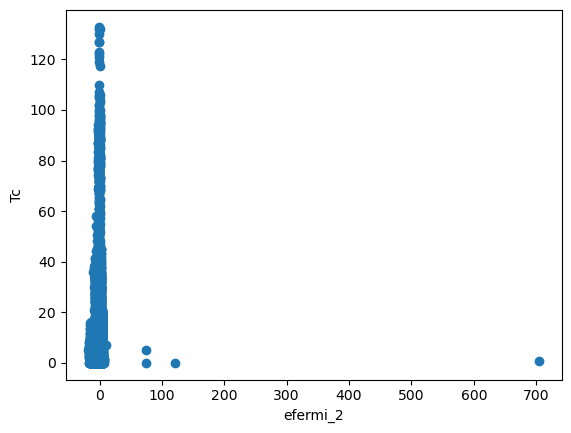

In [89]:
plt.scatter(df_SOAP['3_SOAP'],target)
plt.ylabel('Tc')
plt.xlabel('efermi_2')
plt.show()

In [90]:
pearsonr(target,df_Basic['efermi_2'])

PearsonRResult(statistic=-0.3175734622408654, pvalue=1.9833573861586673e-135)

In [91]:
pearsonr(target,df_Basic['band_gap_2'])

PearsonRResult(statistic=-0.05266602334948726, pvalue=6.241482232947488e-05)

In [92]:
pearsonr(target,df_Basic['latc_2'])

PearsonRResult(statistic=0.3323068318605741, pvalue=7.268902743652396e-149)

In [93]:
pearsonr(target,df_Basic['formation_energy_per_atom_2'])

PearsonRResult(statistic=-0.3354127689356193, pvalue=8.560436747591229e-152)

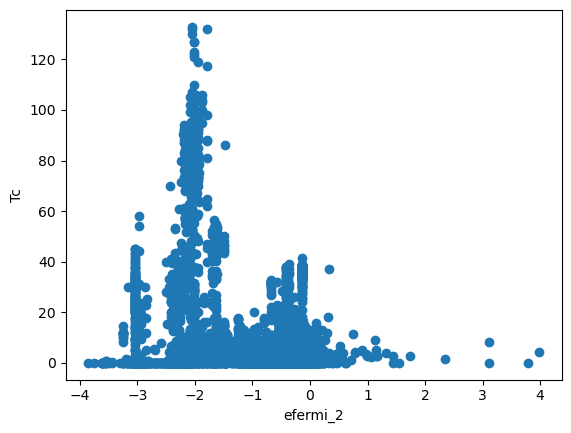

In [94]:
plt.scatter(df_Basic['formation_energy_per_atom_2'],target)
plt.ylabel('Tc')
plt.xlabel('efermi_2')
plt.show()

In [95]:
#Function that allows us to run the ML several times. Average the output. 
def runKRR_NTimes(N,features,targets,gam,alp):
    MSLE = []
    
    for i in range(N):
        #Split the data and targets into test train
        X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.33)
        #Apply KRR ML
        KRR = KernelRidge(kernel="rbf", gamma=gam,alpha=alp)
        KRR.fit(X_train, y_train)

        #Predict based on X_test
        KRR_pred=KRR.predict(X_test)

        #If our prediction for Tc is negative, we should set the Tc to 0.
        #Make a copy before we start changing elements in the dataframe to avoind warnings. 
        KRR_pred_Pos = KRR_pred.copy()
        #Set negative values to positive
        for i in range(len(KRR_pred_Pos)):
            if KRR_pred_Pos[i]<0:
                KRR_pred_Pos[i]=0

        #Find the mean square log error (MSLE)
        MSLE.append(mean_squared_log_error(y_test, KRR_pred_Pos))
    return MSLE


In [96]:
df_M_S = df_SOAP.join(df_MAGPIE)

In [97]:
# res = runKRR_NTimes(10,df_M_S,target,.1,.12)
# sum(res)/len(res)

In [98]:
#Function that allows us to run the ML several times. This function scales the Tc
#Average the output of this function after using. 
def runKRR_NTimes_log(N,features,targets,gam,alp):
    MSLE = []
    targets_L = np.arcsinh(targets)
    for i in range(N):
        #Split the data and targets into test train
        X_train, X_test, y_train, y_test = train_test_split(features, targets_L, test_size=0.2)
        #Apply KRR ML
        KRR = KernelRidge(kernel="laplacian", gamma=gam,alpha=alp)

        KRR.fit(X_train, y_train)

        #Predict based on X_test
        KRR_pred=KRR.predict(X_test)

        #If our prediction for Tc is negative, we should set the Tc to 0.
        #Make a copy before we start changing elements in the dataframe to avoind warnings. 
        KRR_pred_Pos = KRR_pred.copy()
        #Set negative values to positive
        for i in range(len(KRR_pred_Pos)):
            if KRR_pred_Pos[i]<0:
                KRR_pred_Pos[i]=0

        #Find the mean square log error (MSLE)
        MSLE.append(mean_squared_log_error(np.sinh(y_test), np.sinh(KRR_pred_Pos)))
    return MSLE


In [99]:
res = runKRR_NTimes_log(50,df_M_S,target,.1,.12)
sum(res)/len(res)

0.5796194720424153

In [100]:
#For MAGPIE 7 PCA features and SOAP 4 PCA features .1, .12 hyperparams: MSLE_avg=0.67

In [101]:
#Function that allows us to run the ML several times. This function scales the Tc
#Average the output of this function after using. 
def runKRR_R2(N,features,targets,gam,alp):
    R2 = []
    targets_L = np.arcsinh(targets)
    for i in range(N):
        #Split the data and targets into test train
        X_train, X_test, y_train, y_test = train_test_split(features, targets_L, test_size=0.2)
        #Apply KRR ML
        KRR = KernelRidge(kernel="laplacian", gamma=gam,alpha=alp)

        KRR.fit(X_train, y_train)

        #Predict based on X_test
        KRR_pred=KRR.predict(X_test)

        #If our prediction for Tc is negative, we should set the Tc to 0.
        #Make a copy before we start changing elements in the dataframe to avoind warnings. 
        KRR_pred_Pos = KRR_pred.copy()
        #Set negative values to positive
        for i in range(len(KRR_pred_Pos)):
            if KRR_pred_Pos[i]<0:
                KRR_pred_Pos[i]=0

        #Find the mean square log error (MSLE)
        R2.append(r2_score(np.sinh(y_test), np.sinh(KRR_pred_Pos)))
    return R2


In [102]:
res = runKRR_R2(50,df_M_S,target,.1,.12)
sum(res)/len(res)

0.6733340904222129

In [103]:
df_M_S_X = df_M_S.join(df_Basic['efermi_2'])
res = runKRR_R2(10,df_M_S_X,target,.1,.12)
sum(res)/len(res)

0.6801145375673452

In [106]:
res = runKRR_NTimes_log(10,df_M_S_X,target,.1,.12)
sum(res)/len(res)

0.5722939618875479

In [62]:
df_M_S_X = df_M_S.join(df_Basic['formation_energy_per_atom_2'])
res = runKRR_R2(50,df_M_S_X,target,.1,.12)
sum(res)/len(res)

0.673111506204944

In [64]:
df_M_S_X = df_M_S.join(df_Basic['latc_2'])
res = runKRR_R2(50,df_M_S_X,target,.1,.12)
sum(res)/len(res)

0.6775909584080827

In [78]:
# df_M_S_X = df_Basic['efermi_2'].join(df_Basic['latc_2'])
# df_M_S_X = df_M_S_X.join(df_Basic['formation_energy_per_atom_2'])
df_M_S_X = pd.concat([df_Basic['efermi_2'],df_Basic['latc_2'],df_Basic['lata_2'],df_Basic['formation_energy_per_atom_2']],axis=1)


res = runKRR_R2(50,df_M_S_X,target,2,.12)
sum(res)/len(res)

0.6319442665665895

In [84]:
res = runKRR_NTimes_log(50,df_M_S_X,target,2,.12)
sum(res)/len(res)

0.7673286748198875

In [85]:
df_M_S_X = pd.concat([df_M_S,df_Basic['efermi_2'],df_Basic['latc_2'],df_Basic['formation_energy_per_atom_2']],axis=1)


res = runKRR_NTimes_log(50,df_M_S_X,target,2,.12)
sum(res)/len(res)

1.9091385749673395